In [8]:
import argparse
import yaml
import os
import logging
import shutil
import numpy as np
from PIL import Image 
logger = logging.getLogger()
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
logger.addHandler(handler)

import torch
import torch.optim as optim
import torchvision.transforms as transforms
from diffusers import DDIMScheduler
from datasets import load_dataset
from diffusers.utils.torch_utils import randn_tensor

from main.wmdiffusion import WMDetectStableDiffusionPipeline
from main.wmpatch import GTWatermark, GTWatermarkMulti
from main.utils import *
from loss.loss import LossProvider
from loss.pytorch_ssim import ssim

os.environ["CUDA_VISIBLE_DEVICES"] = '5'

## Necessary Setup for All Sections

In [9]:
logging.info(f'===== Load Config =====')
device = torch.device('cuda')
with open('./example/config/config.yaml', 'r') as file:
    cfgs = yaml.safe_load(file)
logging.info(cfgs)

===== Load Config =====
===== Load Config =====
{'method': 'ZoDiac', 'save_img': './example/output/', 'model_id': 'stabilityai/stable-diffusion-2-1-base', 'gen_seed': 0, 'empty_prompt': True, 'w_type': 'single', 'w_channel': 3, 'w_radius': 10, 'w_seed': 10, 'start_latents': 'init_w', 'iters': 100, 'save_iters': [100], 'loss_weights': [10.0, 0.1, 1.0, 0.0], 'ssim_threshold': 0.92, 'detect_threshold': 0.9}
{'method': 'ZoDiac', 'save_img': './example/output/', 'model_id': 'stabilityai/stable-diffusion-2-1-base', 'gen_seed': 0, 'empty_prompt': True, 'w_type': 'single', 'w_channel': 3, 'w_radius': 10, 'w_seed': 10, 'start_latents': 'init_w', 'iters': 100, 'save_iters': [100], 'loss_weights': [10.0, 0.1, 1.0, 0.0], 'ssim_threshold': 0.92, 'detect_threshold': 0.9}


In [10]:
logging.info(f'===== Init Pipeline =====')
if cfgs['w_type'] == 'single':
    wm_pipe = GTWatermark(device, w_channel=cfgs['w_channel'], w_radius=cfgs['w_radius'], generator=torch.Generator(device).manual_seed(cfgs['w_seed']))
elif cfgs['w_type'] == 'multi':
    wm_pipe = GTWatermarkMulti(device, w_settings=cfgs['w_settings'], generator=torch.Generator(device).manual_seed(cfgs['w_seed']))

scheduler = DDIMScheduler.from_pretrained(cfgs['model_id'], subfolder="scheduler")
pipe = WMDetectStableDiffusionPipeline.from_pretrained(cfgs['model_id'], scheduler=scheduler).to(device)
pipe.set_progress_bar_config(disable=True)

===== Init Pipeline =====
===== Init Pipeline =====


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
imagename = 'pepper.tiff'
gt_img_tensor = get_img_tensor(f'./example/input/{imagename}', device)
wm_path = cfgs['save_img']

## Image Watermarking

In [13]:
# Step 1: Get init noise
def get_init_latent(img_tensor, pipe, text_embeddings, guidance_scale=1.0):
    # DDIM inversion from the given image
    img_latents = pipe.get_image_latents(img_tensor, sample=False)
    reversed_latents = pipe.forward_diffusion(
        latents=img_latents,
        text_embeddings=text_embeddings,
        guidance_scale=guidance_scale,
        num_inference_steps=50,
    )
    return reversed_latents

empty_text_embeddings = pipe.get_text_embedding('')
init_latents_approx = get_init_latent(gt_img_tensor, pipe, empty_text_embeddings)

In [14]:
# Step 2: prepare training
init_latents = init_latents_approx.detach().clone()
init_latents.requires_grad = True
optimizer = optim.Adam([init_latents], lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.3) 

totalLoss = LossProvider(cfgs['loss_weights'], device)
loss_lst = [] 

In [15]:
# Step 3: train the init latents
for i in range(cfgs['iters']):
    logging.info(f'iter {i}:')
    init_latents_wm = wm_pipe.inject_watermark(init_latents)
    if cfgs['empty_prompt']:
        pred_img_tensor = pipe('', guidance_scale=1.0, num_inference_steps=50, output_type='tensor', use_trainable_latents=True, init_latents=init_latents_wm).images
    else:
        pred_img_tensor = pipe(prompt, num_inference_steps=50, output_type='tensor', use_trainable_latents=True, init_latents=init_latents_wm).images
    loss = totalLoss(pred_img_tensor, gt_img_tensor, init_latents_wm, wm_pipe)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_lst.append(loss.item())
    # save watermarked image
    if (i+1) in cfgs['save_iters']:
        path = os.path.join(wm_path, f"{imagename.split('.')[0]}_{i+1}.png")
        save_img(path, pred_img_tensor, pipe)
torch.cuda.empty_cache()

iter 0:
iter 0:
Watermark 0.0000, Image 0.5735, Perp 0.9297, SSIM 0.5659 Total Loss 2.0691
Watermark 0.0000, Image 0.5735, Perp 0.9297, SSIM 0.5659 Total Loss 2.0691
iter 1:
iter 1:
Watermark 0.0000, Image 0.4473, Perp 0.8596, SSIM 0.5190 Total Loss 1.8259
Watermark 0.0000, Image 0.4473, Perp 0.8596, SSIM 0.5190 Total Loss 1.8259
iter 2:
iter 2:
Watermark 0.0000, Image 0.3822, Perp 0.8214, SSIM 0.4938 Total Loss 1.6974
Watermark 0.0000, Image 0.3822, Perp 0.8214, SSIM 0.4938 Total Loss 1.6974
iter 3:
iter 3:
Watermark 0.0000, Image 0.3420, Perp 0.7934, SSIM 0.4765 Total Loss 1.6118
Watermark 0.0000, Image 0.3420, Perp 0.7934, SSIM 0.4765 Total Loss 1.6118
iter 4:
iter 4:
Watermark 0.0000, Image 0.3173, Perp 0.7856, SSIM 0.4723 Total Loss 1.5753
Watermark 0.0000, Image 0.3173, Perp 0.7856, SSIM 0.4723 Total Loss 1.5753
iter 5:
iter 5:
Watermark 0.0000, Image 0.2771, Perp 0.7414, SSIM 0.4473 Total Loss 1.4658
Watermark 0.0000, Image 0.2771, Perp 0.7414, SSIM 0.4473 Total Loss 1.4658
iter

In [16]:
init_latents_wm

tensor([[[[ 0.5295,  0.9895, -0.3657,  ...,  1.8704,  0.1185,  0.5272],
          [-0.6611, -1.2703, -0.1041,  ...,  0.2033,  0.6121, -1.6536],
          [-0.5201,  1.0838,  0.2337,  ...,  0.7931,  0.1809,  0.2334],
          ...,
          [-1.3868,  1.5198, -0.2730,  ..., -1.5986,  1.1063,  1.7891],
          [-0.0137, -0.0522, -0.3507,  ..., -0.7220,  0.7129, -0.6526],
          [-0.3919,  1.0628,  0.9342,  ...,  2.4099, -0.9091,  0.7796]],

         [[-0.4908, -1.1860,  0.6235,  ...,  0.8106,  1.2712, -0.4923],
          [-0.2267,  0.9769, -0.7372,  ...,  1.6074,  1.5930,  0.3276],
          [-0.6307, -0.0730, -0.6344,  ...,  1.3092,  1.5043,  0.0256],
          ...,
          [-1.4427, -0.1651,  1.8103,  ...,  1.2750,  0.4123,  1.4018],
          [-3.1571,  1.1805,  0.8177,  ...,  2.7709,  0.2851,  0.0603],
          [ 1.7003, -1.2459,  1.0615,  ...,  0.3503, -0.1711,  1.8223]],

         [[-0.2323, -0.5336, -0.9116,  ...,  0.4437, -2.7375, -1.1828],
          [-1.5927, -0.1723, -

In [17]:
import matplotlib.pyplot as plt
def visualize_tensor(tensor, name='./tmp.png'):
    channels = tensor.squeeze(0).cpu().numpy()
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    for i, ax in enumerate(axs):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

    plt.savefig(name)
    plt.show()


In [20]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_with_bounding_box(tensor, channel=3, r=10, name='./ring_with_bbox.png'):
#     # Extract all channels
#     channels = tensor.squeeze(0).cpu().numpy()

#     fig, axs = plt.subplots(1, channels.shape[0], figsize=(12, 3))

#     for i, ax in enumerate(axs):
#         ax.imshow(channels[i], cmap='gray')
#         ax.set_title(f'Channel {i+1}')
#         ax.axis('off')

#         # Add bounding box only to the specified channel
#         if i == channel:
#             size = channels[i].shape[0]
#             center = size // 2
#             mask = _circle_mask(size=size, r=r)

#             # Get the bounding box of the ring
#             y, x = np.where(mask)
#             x_min, x_max = x.min(), x.max()
#             y_min, y_max = y.min(), y.max()

#             # Add a bounding box
#             bbox = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
#                                  edgecolor='red', facecolor='none', linewidth=2)
#             ax.add_patch(bbox)

#     # Save and show the image
#     plt.savefig(name)
#     plt.show()

def plot_with_bounding_box(tensor, channel=3, r=10, expansion=3, name='./ring_with_bbox.png'):
    # Extract all channels
    channels = tensor.squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(1, channels.shape[0], figsize=(12, 3))

    for i, ax in enumerate(axs):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

        # Add bounding box only to the specified channel
        if i == channel:
            size = channels[i].shape[0]
            center = size // 2
            mask = wm_pipe._circle_mask(size=size, r=r)

            # Get the bounding box of the ring
            y, x = np.where(mask)
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()

            # Expand the bounding box by a specified amount
            x_min = max(x_min - expansion, 0)
            x_max = min(x_max + expansion, size - 1)
            y_min = max(y_min - expansion, 0)
            y_max = min(y_max + expansion, size - 1)

            # Add a bounding box
            bbox = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(bbox)

    # Save and show the image
    plt.savefig(name)
    plt.show()




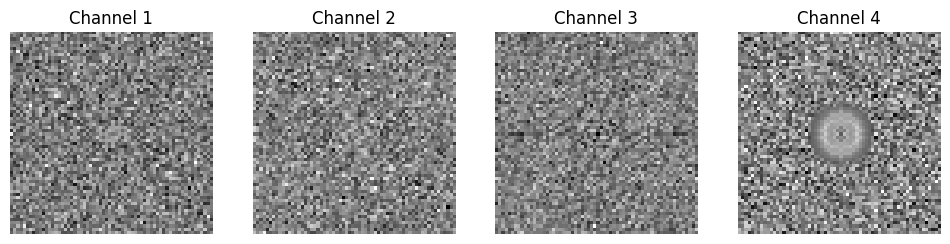

In [18]:
init_latents_w_fft_real = torch.fft.fftshift(torch.fft.fft2(init_latents_wm), dim=(-1, -2)).real
visualize_tensor(init_latents_w_fft_real.detach().cpu(), name='./real.png')


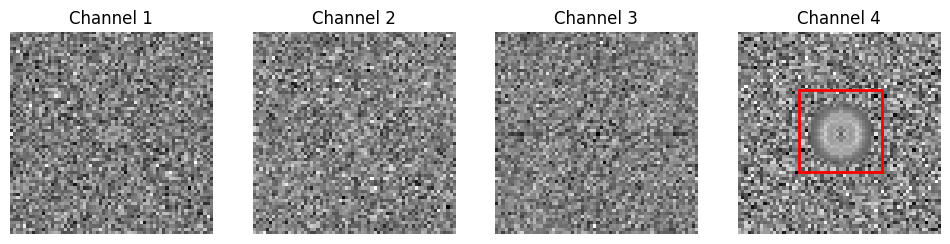

In [22]:
# Assuming init_latents_w_fft is already defined as the FFT of the watermark latents
plot_with_bounding_box(init_latents_w_fft_real.detach().cpu(), channel=3, r=10, name='./zodiac_real_with_bbox.png')


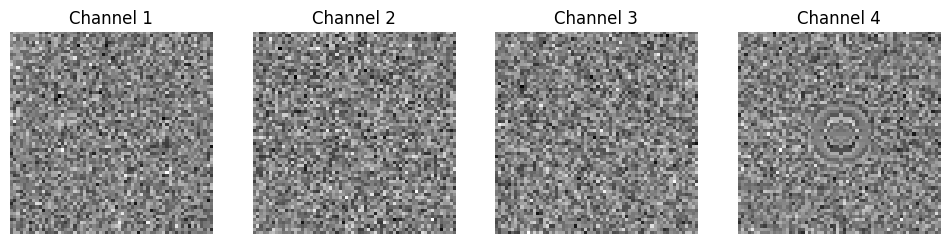

In [19]:
init_latents_w_fft_img = torch.fft.fftshift(torch.fft.fft2(init_latents_wm), dim=(-1, -2)).imag
visualize_tensor(init_latents_w_fft_img.detach().cpu(), name='./imag.png')


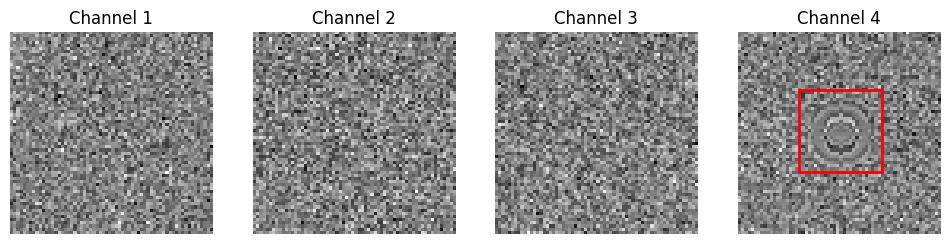

In [23]:
plot_with_bounding_box(init_latents_w_fft_img.detach().cpu(), channel=3, r=10, name='./zodiac_imag_with_bbox.png')


In [17]:
# import torch
# import matplotlib.pyplot as plt

# # Initialize the watermark class (using GTWatermark as an example)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# watermark = GTWatermark(device, shape=(1, 4, 64, 64))

# # Get the watermarking pattern
# pattern = watermark.gt_patch

# # Convert the pattern to CPU and numpy for plotting
# pattern_np = pattern.cpu().numpy()

# # Plot the pattern
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for i in range(4):
#     axs[i].imshow(np.abs(pattern_np[0, i]), cmap='gray')
#     axs[i].set_title(f'Channel {i+1}')
#     axs[i].axis('off')

# plt.suptitle('Watermarking Pattern')
# plt.tight_layout()
# plt.show()

In [18]:
# def generate_and_plot_noise(shape):
#     noise_vector = np.random.normal(size=shape)
#     return noise_vector

# noise_vec = generate_and_plot_noise((512, 512, 1))

# gt_init = torch.tensor(noise_vec[:, :, 0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 256, 256)
# watermarking_pattern = wm_pipe._get_watermarking_pattern(gt_init)

# plt.figure()

# plt.subplot(1, 4, 3)
# plt.imshow(torch.abs(watermarking_pattern).squeeze().cpu().numpy(), cmap='gray')
# plt.title("Watermarking Pattern")
# plt.xlabel("Frequency X")
# plt.ylabel("Frequency Y")


# plt.show()




## Postprocessing with Adaptive Enhancement

In [19]:
# hyperparameter
ssim_threshold = cfgs['ssim_threshold']

In [20]:
wm_img_path = os.path.join(wm_path, f"{imagename.split('.')[0]}_{cfgs['save_iters'][-1]}.png")
wm_img_tensor = get_img_tensor(wm_img_path, device)
ssim_value = ssim(wm_img_tensor, gt_img_tensor).item()
logging.info(f'Original SSIM {ssim_value}')

Original SSIM 0.6713976263999939


In [21]:
def binary_search_theta(threshold, lower=0., upper=1., precision=1e-6, max_iter=1000):
    for i in range(max_iter):
        mid_theta = (lower + upper) / 2
        img_tensor = (gt_img_tensor-wm_img_tensor)*mid_theta+wm_img_tensor
        ssim_value = ssim(img_tensor, gt_img_tensor).item()

        if ssim_value <= threshold:
            lower = mid_theta
        else:
            upper = mid_theta
        if upper - lower < precision:
            break
    return lower

optimal_theta = binary_search_theta(ssim_threshold, precision=0.01)
logging.info(f'Optimal Theta {optimal_theta}')

img_tensor = (gt_img_tensor-wm_img_tensor)*optimal_theta+wm_img_tensor

ssim_value = ssim(img_tensor, gt_img_tensor).item()
psnr_value = compute_psnr(img_tensor, gt_img_tensor)

tester_prompt = '' 
text_embeddings = pipe.get_text_embedding(tester_prompt)
det_prob = 1 - watermark_prob(img_tensor, pipe, wm_pipe, text_embeddings)

path = os.path.join(wm_path, f"{os.path.basename(wm_img_path).split('.')[0]}_SSIM{ssim_threshold}.png")
save_img(path, img_tensor, pipe)
logging.info(f'SSIM {ssim_value}, PSNR, {psnr_value}, Detect Prob: {det_prob} after postprocessing')

Optimal Theta 0.5625
SSIM 0.9196219444274902, PSNR, 26.825482204904844, Detect Prob: 0.9999999986261296 after postprocessing


In [22]:
from diffusers import AutoPipelineForText2Image
from diffusers import AutoPipelineForImage2Image

paraphrase_model_id = 'stabilityai/stable-diffusion-xl-base-1.0'
# model_id = 'stabilityai/stable-diffusion-2-1-base'

pipeline_text2image = AutoPipelineForText2Image.from_pretrained(paraphrase_model_id, torch_dtype=torch.float16, variant="fp16", use_safetensors=True, add_watermarker=False).to(device)
pipeline = AutoPipelineForImage2Image.from_pipe(pipeline_text2image).to(device)


/raid/home/ashhar21137/anaconda3/envs/zodiac/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

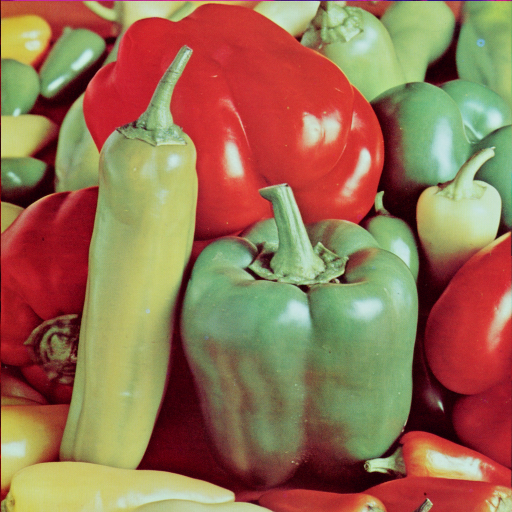

In [24]:
neg_prompt = 'deformity, bad anatomy, cloned face, amputee, people in background, asymmetric, disfigured, extra limbs, text, missing legs, missing arms, Out of frame, low quality, Poorly drawn feet'
init_image = Image.open(path)

init_image

In [37]:
captions = 'Image of various vegetables'

In [40]:
gen_image = pipeline(captions, image=init_image, negative_prompt=neg_prompt, strength=0.2, guidance_scale=6).images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

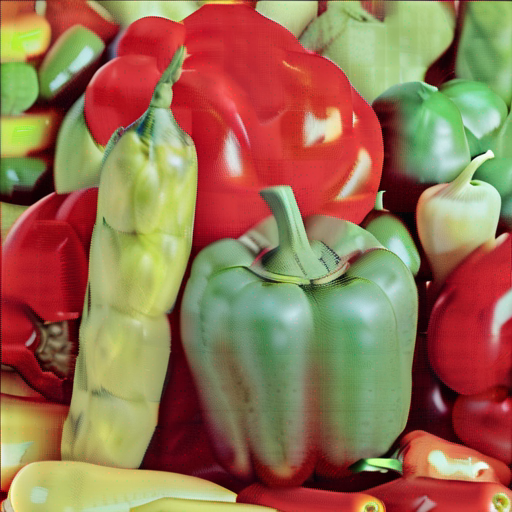

In [41]:
gen_image

In [45]:
from main.utils import *

In [46]:
tester_prompt = '' 
text_embeddings = pipe.get_text_embedding(tester_prompt)
prob, rev_latent = watermark_prob(img_tensor, pipe, wm_pipe, text_embeddings)
print(1-prob)

TypeError: cannot unpack non-iterable numpy.float64 object

## Attack Watermarked Image with Individual Attacks

In [ ]:
from main.wmattacker import *
from main.attdiffusion import ReSDPipeline

logging.info(f'===== Init Attackers =====')
att_pipe = ReSDPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16, revision="fp16")
att_pipe.set_progress_bar_config(disable=True)
att_pipe.to(device)

attackers = {
    'diff_attacker_60': DiffWMAttacker(att_pipe, batch_size=5, noise_step=60, captions={}),
    'cheng2020-anchor_3': VAEWMAttacker('cheng2020-anchor', quality=3, metric='mse', device=device),
    'bmshj2018-factorized_3': VAEWMAttacker('bmshj2018-factorized', quality=3, metric='mse', device=device),
    'jpeg_attacker_50': JPEGAttacker(quality=50),
    'rotate_90': RotateAttacker(degree=90),
    'brightness_0.5': BrightnessAttacker(brightness=0.5),
    'contrast_0.5': ContrastAttacker(contrast=0.5),
    'Gaussian_noise': GaussianNoiseAttacker(std=0.05),
    'Gaussian_blur': GaussianBlurAttacker(kernel_size=5, sigma=1),
    'bm3d': BM3DAttacker(),
}

In [ ]:
logging.info(f'===== Start Attacking... =====')

post_img = os.path.join(wm_path, f"{imagename.split('.')[0]}_{cfgs['save_iters'][-1]}_SSIM{ssim_threshold}.png")
for attacker_name, attacker in attackers.items():
    print(f'Attacking with {attacker_name}')
    os.makedirs(os.path.join(wm_path, attacker_name), exist_ok=True)
    att_img_path = os.path.join(wm_path, attacker_name, os.path.basename(post_img))
    attackers[attacker_name].attack([post_img], [att_img_path])

## Attack Watermarked Image with Combined Attacks

In [ ]:
from main.wmattacker import *
from main.attdiffusion import ReSDPipeline

case_list = ['w/ rot', 'w/o rot']

logging.info(f'===== Init Attackers =====')
att_pipe = ReSDPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16, revision="fp16")
att_pipe.set_progress_bar_config(disable=True)
att_pipe.to(device)

In [ ]:
post_img = os.path.join(wm_path, f"{imagename.split('.')[0]}_{cfgs['save_iters'][-1]}_SSIM{ssim_threshold}.png")

for case in case_list:
    print(f'Case: {case}')
    if case == 'w/ rot':
        attackers = {
        'diff_attacker_60': DiffWMAttacker(att_pipe, batch_size=5, noise_step=60, captions={}),
        'cheng2020-anchor_3': VAEWMAttacker('cheng2020-anchor', quality=3, metric='mse', device=device),
        'bmshj2018-factorized_3': VAEWMAttacker('bmshj2018-factorized', quality=3, metric='mse', device=device),
        'jpeg_attacker_50': JPEGAttacker(quality=50),
        'rotate_90': RotateAttacker(degree=90),
        'brightness_0.5': BrightnessAttacker(brightness=0.5),
        'contrast_0.5': ContrastAttacker(contrast=0.5),
        'Gaussian_noise': GaussianNoiseAttacker(std=0.05),
        'Gaussian_blur': GaussianBlurAttacker(kernel_size=5, sigma=1),
        'bm3d': BM3DAttacker(),
        }
        multi_name = 'all'
    elif case == 'w/o rot':
        attackers = {
        'diff_attacker_60': DiffWMAttacker(att_pipe, batch_size=5, noise_step=60, captions={}),
        'cheng2020-anchor_3': VAEWMAttacker('cheng2020-anchor', quality=3, metric='mse', device=device),
        'bmshj2018-factorized_3': VAEWMAttacker('bmshj2018-factorized', quality=3, metric='mse', device=device),
        'jpeg_attacker_50': JPEGAttacker(quality=50),
        'brightness_0.5': BrightnessAttacker(brightness=0.5),
        'contrast_0.5': ContrastAttacker(contrast=0.5),
        'Gaussian_noise': GaussianNoiseAttacker(std=0.05),
        'Gaussian_blur': GaussianBlurAttacker(kernel_size=5, sigma=1),
        'bm3d': BM3DAttacker(),
        }
        multi_name = 'all_norot'
        
    
    os.makedirs(os.path.join(wm_path, multi_name), exist_ok=True)
    att_img_path = os.path.join(wm_path, multi_name, os.path.basename(post_img))
    for i, (attacker_name, attacker) in enumerate(attackers.items()):
        print(f'Attacking with {attacker_name}')
        if i == 0:
            attackers[attacker_name].attack([post_img], [att_img_path], multi=True)
        else:
            attackers[attacker_name].attack([att_img_path], [att_img_path], multi=True)

## Detect Watermark

In [ ]:
post_img = os.path.join(wm_path, f"{imagename.split('.')[0]}_{cfgs['save_iters'][-1]}_SSIM{ssim_threshold}.png")

attackers = ['diff_attacker_60', 'cheng2020-anchor_3', 'bmshj2018-factorized_3', 'jpeg_attacker_50', 
             'brightness_0.5', 'contrast_0.5', 'Gaussian_noise', 'Gaussian_blur', 'rotate_90', 'bm3d', 
             'all', 'all_norot']

tester_prompt = '' # assume at the detection time, the original prompt is unknown
text_embeddings = pipe.get_text_embedding(tester_prompt)

In [ ]:
logging.info(f'===== Testing the Watermarked Images {post_img} =====')
det_prob = 1 - watermark_prob(post_img, pipe, wm_pipe, text_embeddings)
logging.info(f'Watermark Presence Prob.: {det_prob}')

In [ ]:
logging.info(f'===== Testing the Attacked Watermarked Images =====')
for attacker_name in attackers:
    if not os.path.exists(os.path.join(wm_path, attacker_name)):
        logging.info(f'Attacked images under {attacker_name} not exist.')
        continue
        
    logging.info(f'=== Attacker Name: {attacker_name} ===')
    det_prob = 1 - watermark_prob(os.path.join(wm_path, attacker_name, os.path.basename(post_img)), pipe, wm_pipe, text_embeddings)
    logging.info(f'Watermark Presence Prob.: {det_prob}')